In [10]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [11]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'Used_Dataset/cleaned_data')
# Read the data
train_data = pd.read_csv(os.path.join(used_dataset_dir, 'cleaned_data_2020_2022.csv'))
display(train_data.isnull().sum())
display(train_data.shape)



Date      0
Tn        0
Tx        0
Tavg      0
RH_avg    0
RR        0
ss        0
ff_x      0
ddd_x     0
ff_avg    0
rad(m)    0
dtype: int64

(731, 11)

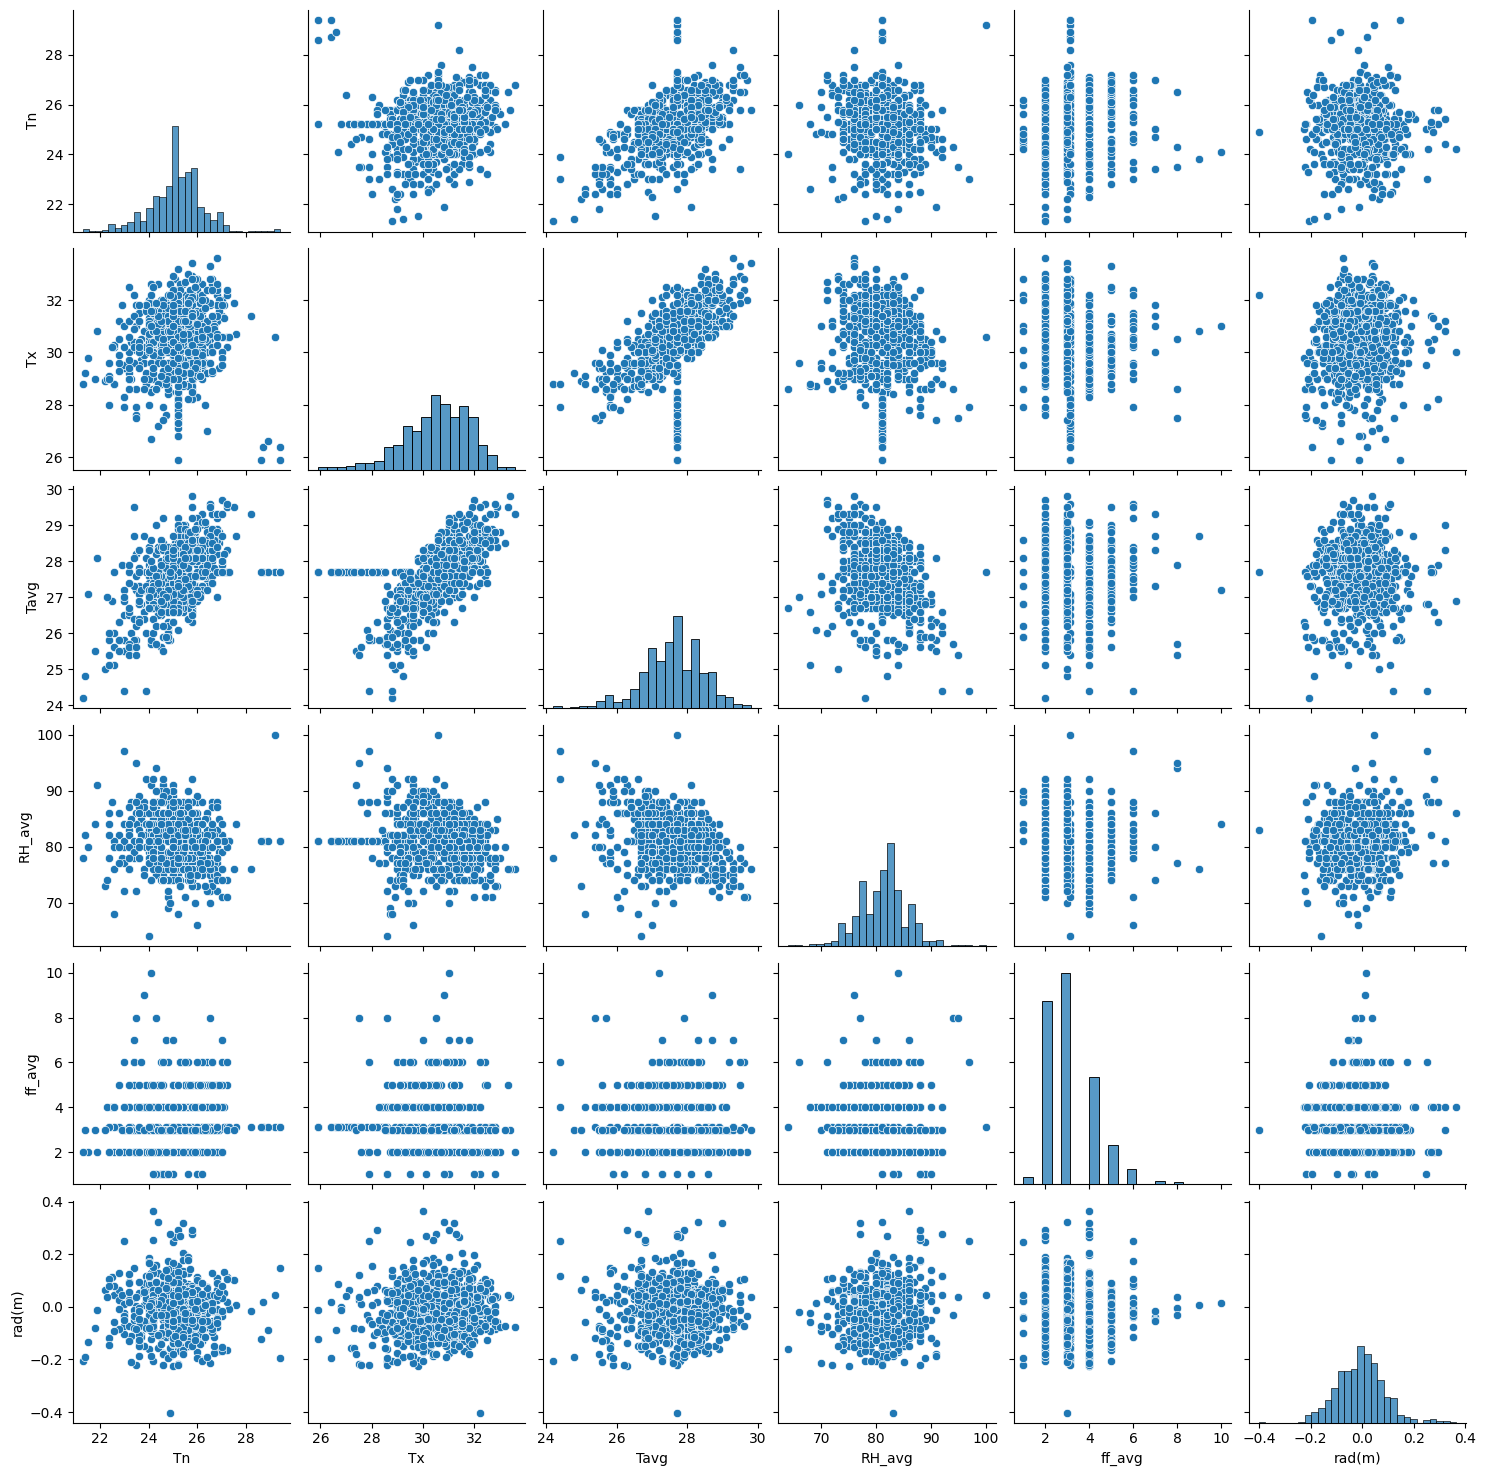

In [12]:
# Pair plot to visualize relationships between features
sns.pairplot(train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']])
plt.show()

Correlation Matrix

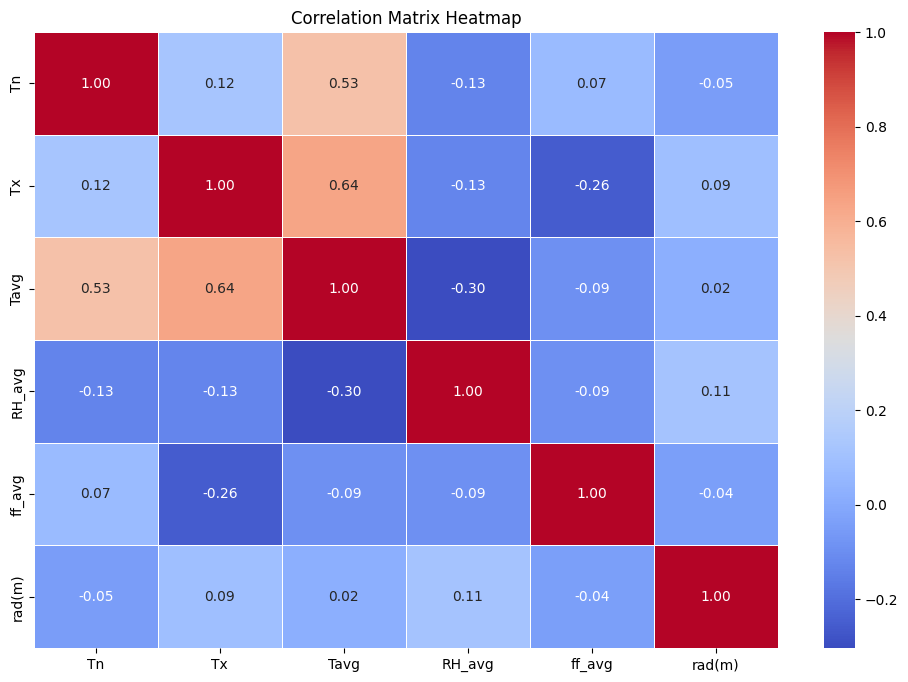

In [13]:
# Calculate the correlation matrix
correlation_matrix = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'rad(m)']].corr()

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

Linear Regression Process Start Here


In [14]:
# Custom Accuracy Metric for Regression: Predictions within a tolerance range
class RegressionAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="regression_accuracy", tolerance=0.05, **kwargs):
        super().__init__(name=name, **kwargs)
        self.tolerance = tolerance
        self.correct_predictions = self.add_weight(name="correct_predictions", initializer="zeros")
        self.total_predictions = self.add_weight(name="total_predictions", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_true - y_pred)
        within_tolerance = tf.cast(error <= self.tolerance, tf.float32)
        self.correct_predictions.assign_add(tf.reduce_sum(within_tolerance))
        self.total_predictions.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.correct_predictions / self.total_predictions

    def reset_states(self):
        self.correct_predictions.assign(0)
        self.total_predictions.assign(0)
        
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [15]:
# # Load your training data
# # X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'ss', 'ddd_x', 'RR', 'ff_x']]  # Add more features if needed
# X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']]
# y = train_data['rad(m)']


# # Membagi data menjadi data training dan testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Normalisasi fitur menggunakan StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Membangun model neural network
# model = Sequential()
# model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Layer pertama dengan 64 neuron
# model.add(Dense(32, activation='relu'))  # Layer kedua dengan 32 neuron
# model.add(Dense(1))  # Layer output (1 output karena regresi)

# # Menyusun model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', RegressionAccuracy(tolerance=0.05)])

# # Melatih model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# results = pd.DataFrame(history.history)
# results[['loss', 'val_loss']].plot()

# # Evaluasi model
# y_pred = model.predict(X_test)


# # Evaluate the model performance
# results = model.evaluate(X_test, y_test, verbose=0)

# # Display the results
# final_loss, final_mae, final_accuracy = results

# print(f"Final Loss: {final_loss:.4f}")
# print(f"Final MAE: {final_mae:.4f}")
# print(f"Final Accuracy: {final_accuracy:.4f}")

# # Plot predictions vs actual values
# y_pred = model.predict(X_test).flatten()
# plt.plot(y_test.values, label="True")
# plt.plot(y_pred, label="Predicted")
# plt.legend()
# plt.title("Predicted vs Actual rad(m)")
# plt.show()


# # Hitung metrik evaluasi
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error: {mse}")
# print(f"R2 Score: {r2}")

Epoch 1/150


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.7584 - mae: 0.6867 - regression_accuracy: 0.0427 - val_loss: 0.0190 - val_mae: 0.1165 - val_regression_accuracy: 0.1837 - learning_rate: 0.0010
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3336 - mae: 0.4394 - regression_accuracy: 0.0645 - val_loss: 0.0167 - val_mae: 0.1040 - val_regression_accuracy: 0.2789 - learning_rate: 0.0010
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2331 - mae: 0.3789 - regression_accuracy: 0.0973 - val_loss: 0.0160 - val_mae: 0.1035 - val_regression_accuracy: 0.2585 - learning_rate: 0.0010
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1752 - mae: 0.3259 - regression_accuracy: 0.1147 - val_loss: 0.0196 - val_mae: 0.1131 - val_regression_accuracy: 0.2449 - learning_rate: 0.0010
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1168 - mae: 0.2712 - regression_accuracy: 0.1081 - val_loss: 0.0160 - val_mae: 0.0965 - val_regression_accuracy: 0.3810 - learning

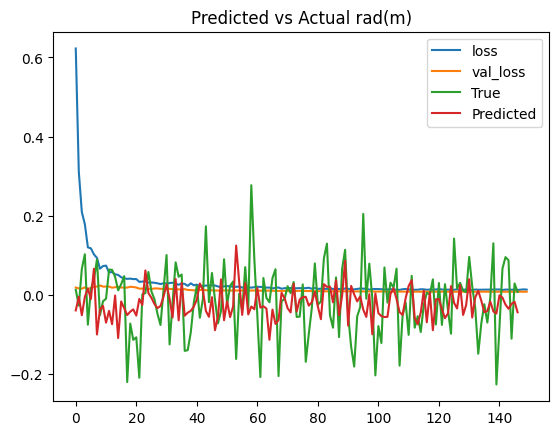

Mean Squared Error: 0.008437920315610697
R2 Score: -0.15222369005981928


In [16]:
# Load your training data
# X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg', 'ss', 'ddd_x', 'RR', 'ff_x']]  # Add more features if needed
X = train_data[['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']]
y = train_data['rad(m)']

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data (Important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)        # Apply the transformation on test set

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # First hidden layer
    BatchNormalization(),  # Batch normalization to stabilize training
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Second hidden layer
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),  # Third hidden layer
    Dense(1)  # Output layer for prediction
])

# Compile the model with Adam optimizer and loss function 'mse'
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae', RegressionAccuracy(tolerance=0.05)])

# Implementing learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=150, validation_data=(X_test_scaled, y_test), batch_size=16, verbose=1, callbacks=[lr_scheduler])
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()

# Evaluate the model performance
results = model.evaluate(X_test_scaled, y_test, verbose=1)

# Display the results
final_loss = results[0]
final_mae = results[1]
final_accuracy = results[2]

print(f"Final Loss: {final_loss:.4f}")
print(f"Final MAE: {final_mae:.4f}")
print(f"Final Accuracy: {final_accuracy:.4f}")

# Plot predictions vs actual values
y_pred = model.predict(X_test_scaled)
plt.plot(y_test.values, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Predicted vs Actual rad(m)")
plt.show()


# # Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

In [17]:

# Define a function for making predictions
def predict_rad(features, scaler, model):
    """
    Predict rad(m) value based on input weather features.

    Parameters:
        features (dict): A dictionary containing all feature values (Tn, Tx, Tavg, RH_avg, RR, ss, ff_x, ddd_x, ff_avg).
        scaler (StandardScaler): Scaler used to normalize the features.
        model (Sequential): Trained deep learning model.

    Returns:
        float: Predicted rad(m) value.
    """
     # Convert input features to a DataFrame with the same column names as the scaler expects
    feature_df = pd.DataFrame([features])
    
    # Scale the input features using the trained scaler
    scaled_features = scaler.transform(feature_df)

    # Predict rad(m) using the trained model
    predicted_value = model.predict(scaled_features)

    # Return the predicted rad(m) value
    return predicted_value[0][0]


In [18]:

input_features = {
    'Tn': 24.5,      # Minimum temperature
    'Tx': 30.0,      # Maximum temperature
    'Tavg': 28.0,    # Average temperature
    'RH_avg': 80.0,  # Average relative humidity
    'ff_avg': 3.0    # Average wind speed
}

# Call the prediction function
predicted_rad = predict_rad(input_features, scaler, model)
print(f"Predicted rad(m): {predicted_rad:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted rad(m): 0.0203
